In [1]:
from methods import *
from L_calc import *

import pandas as pd
import matplotlib.pyplot as plt

Running on cpu.
Model weights loaded successfully


Using cache found in C:\Users\alepa/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified
[0.14922538993069884, 0.051946399758641376, 0.32411100607845683]


In [2]:
from models.LeNet import *
mnist = LeNet("models/lenet_mnist_model.pth")
mnist_model = target_lenet.model
mnist_device = target_lenet.device
mnist_test_loader = target_lenet.testloader

from models.simple_FashionMNIST import *
fmnist = simple_FashionMNIST("models/simple_FashionMNIST.pth")
fmnist_model = fmnist.model
fmnist_device = fmnist.device
fmnist_test_loader = fmnist.testloader

from models.resNet import ResNet20
cifar10 = ResNet20()
cifar10_model = cifar10.model
cifar10_device = cifar10.device
cifar10_test_loader = cifar10.testloader

# L_constants [6.701272487640381, 19.250612258911133, 3.085362672805786]

Running on cpu.
Model weights loaded successfully


Using cache found in C:\Users\alepa/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


Files already downloaded and verified


In [3]:
fw_iters = [15]
eps = 0.03
hist = None
debug = True


all_algos = ['fsgm', 'pgd', 
             'fw', 'fw_momentum', 'fw_l1', 'fw_l2', 'fw_p2', 
             'fw_away', 'fw_away_l1', 'fw_away_l2', 'fw_away_p2',
             'fw_pair', 'fw_pair_l1', 'fw_pair_l2', 'fw_pair_p2']

all_stepsizes = ['fixed', 'decay', 'ls'] # fix armijo and add it

In [4]:
def history_acc_eps(test_fw, datasets, devices, eps, iterations, method='fw_pair', early_stopping='gap_FW',
            fw_stepsize_rule='fixed', gap_FW_tol=0.1):
    accuracies_dict = {name: [] for name in datasets.keys()}
    examples_dict = {name: [] for name in datasets.keys()}
    all_hist_dict = {name: [] for name in datasets.keys()}
    final_hist_dfs_dict = {name: [] for name in datasets.keys()}
    epsilons = [0.001, 0.005, 0.025, 0.05, 0.1]

    for eps in epsilons:
        for name, dataset in datasets.items():
            device = devices[name]
            # Run the test function with the given parameters
            acc, ex, hist = test_fw(dataset, device, eps, iterations, method=method, early_stopping=early_stopping,
                                    fw_stepsize_rule=fw_stepsize_rule, gap_FW_tol=gap_FW_tol)

            # Collect the results
            accuracies_dict[name].append(acc)
            examples_dict[name].append(ex)
            all_hist_dict[name].append(hist)

            # Group by 'example_idx' and get the last row for each group
            final_hist = hist.groupby('example_idx').tail(1)
            final_hist_dfs_dict[name].append(final_hist)

    # Combine all historical dataframes into one for each dataset
    combined_hist_dfs = {name: pd.concat(all_hist).reset_index(drop=True) for name, all_hist in all_hist_dict.items()}
    combined_final_hist_dfs = {name: pd.concat(final_hist).reset_index(drop=True) for name, final_hist in
                               final_hist_dfs_dict.items()}

    # Display the historical dataframes
    for name, hist_df in combined_hist_dfs.items():
        print(f"Historical DataFrame for {name}")
        display(hist_df)

    # Plot the accuracy per epsilon for each dataset
    plt.figure(figsize=(10, 6))
    for name, accuracies in accuracies_dict.items():
        plt.plot(epsilons, accuracies, marker='o', label=name)
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title(f'Algorithm: {method}, Stepsize Method: {fw_stepsize_rule}')
    plt.legend()
    plt.grid(True)
    plt.show()


datasets = {'MNIST': mnist, 'FashionMNIST': fmnist, 'CIFAR-10': cifar10}
devices = {'MNIST': mnist_device, 'FashionMNIST': fmnist_device, 'CIFAR-10': cifar10_device}

### ACC VS EPS pairwise, lipschitz stepsize, different norms

Epsilon: 0.001	Test Accuracy = 992 / 1000 = 0.992
Epsilon: 0.001	Test Accuracy = 870 / 1000 = 0.87
Epsilon: 0.001	Test Accuracy = 474 / 1000 = 0.474
Epsilon: 0.005	Test Accuracy = 983 / 1000 = 0.983
Epsilon: 0.005	Test Accuracy = 526 / 1000 = 0.526
Epsilon: 0.005	Test Accuracy = 16 / 1000 = 0.016
Epsilon: 0.025	Test Accuracy = 903 / 1000 = 0.903
Epsilon: 0.025	Test Accuracy = 21 / 1000 = 0.021
Epsilon: 0.025	Test Accuracy = 49 / 1000 = 0.049
Epsilon: 0.05	Test Accuracy = 302 / 1000 = 0.302
Epsilon: 0.05	Test Accuracy = 29 / 1000 = 0.029
Epsilon: 0.05	Test Accuracy = 61 / 1000 = 0.061
Epsilon: 0.1	Test Accuracy = 7 / 1000 = 0.007
Epsilon: 0.1	Test Accuracy = 41 / 1000 = 0.041
Epsilon: 0.1	Test Accuracy = 34 / 1000 = 0.034
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.071104,False,False,9,9,gap,0.000000
1,1,1,0.050910,False,False,3,3,gap,0.000000
2,2,1,0.055143,False,False,0,0,gap,0.000000
3,3,1,0.067406,False,False,9,9,gap,0.000000
4,4,1,0.066155,False,False,5,5,gap,0.000000
...,...,...,...,...,...,...,...,...,...
14241,998,2,2.914818,True,True,2,8,None,1.908789
14242,998,3,0.001921,True,False,2,8,gap,0.001399
14243,999,1,6.738174,True,True,2,7,None,0.000000
14244,999,2,0.519813,True,False,2,7,None,0.253737


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.964374,False,False,9,9,None,0.000000
1,0,2,0.382317,False,False,9,9,None,0.590578
2,0,3,-0.185004,False,False,9,9,gap,1.118248
3,1,1,0.479053,False,False,2,2,None,0.000000
4,1,2,0.119141,False,False,2,2,None,0.366032
...,...,...,...,...,...,...,...,...,...
17446,999,11,3.652767,True,False,7,9,None,0.414609
17447,999,12,3.652767,True,False,7,9,None,0.414609
17448,999,13,3.652767,True,False,7,9,None,0.414609
17449,999,14,3.652767,True,False,7,9,None,0.414609


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,1.008473,False,False,0,0,None,0.000000e+00
1,0,2,0.180556,False,False,0,0,None,8.011006e-01
2,0,3,-0.438412,True,True,0,5,gap,1.234242e+00
3,1,1,0.566880,False,False,0,0,None,0.000000e+00
4,1,2,0.189923,False,False,0,0,None,3.058368e-01
...,...,...,...,...,...,...,...,...,...
17080,997,2,0.002166,True,False,7,2,gap,9.909180e-05
17081,998,1,153.525146,True,True,8,2,None,0.000000e+00
17082,998,2,0.000393,True,False,8,2,gap,-9.095626e-08
17083,999,1,105.398651,True,True,4,2,None,0.000000e+00


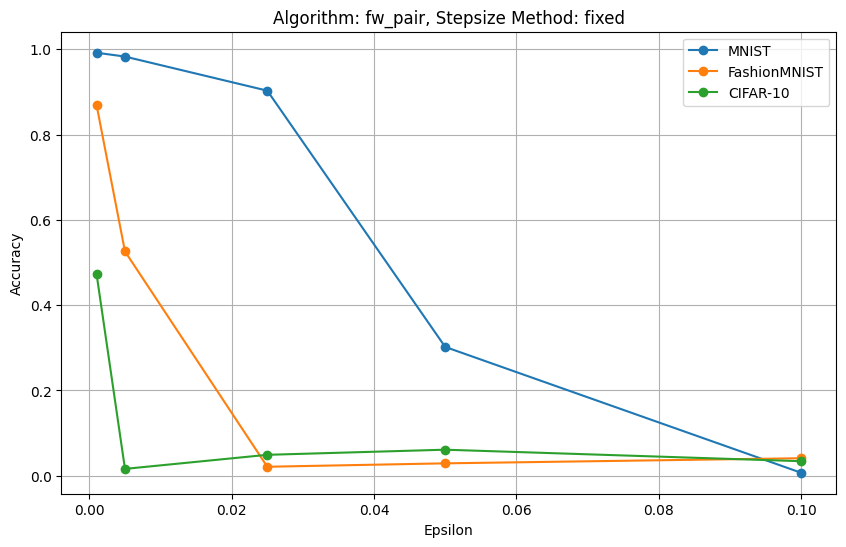

In [5]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair', early_stopping='gap_FW', fw_stepsize_rule='fixed', gap_FW_tol=0.1)

Epsilon: 0.001	Test Accuracy = 990 / 1000 = 0.99
Epsilon: 0.001	Test Accuracy = 886 / 1000 = 0.886
Epsilon: 0.001	Test Accuracy = 771 / 1000 = 0.771
Epsilon: 0.005	Test Accuracy = 985 / 1000 = 0.985
Epsilon: 0.005	Test Accuracy = 814 / 1000 = 0.814
Epsilon: 0.005	Test Accuracy = 32 / 1000 = 0.032
Epsilon: 0.025	Test Accuracy = 889 / 1000 = 0.889
Epsilon: 0.025	Test Accuracy = 23 / 1000 = 0.023
Epsilon: 0.025	Test Accuracy = 62 / 1000 = 0.062
Epsilon: 0.05	Test Accuracy = 434 / 1000 = 0.434
Epsilon: 0.05	Test Accuracy = 29 / 1000 = 0.029
Epsilon: 0.05	Test Accuracy = 48 / 1000 = 0.048
Epsilon: 0.1	Test Accuracy = 6 / 1000 = 0.006
Epsilon: 0.1	Test Accuracy = 41 / 1000 = 0.041
Epsilon: 0.1	Test Accuracy = 41 / 1000 = 0.041
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.015772,False,False,5,5,gap,0.000000
1,1,1,0.018137,False,False,1,1,gap,0.000000
2,2,1,0.017804,False,False,4,4,gap,0.000000
3,3,1,0.017991,False,False,4,4,gap,0.000000
4,4,1,0.017951,False,False,9,9,gap,0.000000
...,...,...,...,...,...,...,...,...,...
17851,999,11,0.465446,True,False,3,8,None,1.693254
17852,999,12,0.465446,True,False,3,8,None,1.693254
17853,999,13,0.465446,True,False,3,8,None,1.693254
17854,999,14,0.465446,True,False,3,8,None,1.693254


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.012190,False,False,9,9,gap,0.000000
1,1,1,0.016750,False,False,2,2,gap,0.000000
2,2,1,0.013429,False,False,1,1,gap,0.000000
3,3,1,0.012161,False,False,1,1,gap,0.000000
4,4,1,0.016396,False,False,6,6,gap,0.000000
...,...,...,...,...,...,...,...,...,...
36590,999,11,1.414718,True,False,7,9,None,0.160578
36591,999,12,1.414718,True,False,7,9,None,0.160578
36592,999,13,1.414718,True,False,7,9,None,0.160578
36593,999,14,1.414718,True,False,7,9,None,0.160578


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.033657,False,False,4,4,gap,0.000000
1,1,1,0.032636,False,False,0,0,gap,0.000000
2,2,1,0.038012,True,True,9,1,gap,0.000000
3,3,1,0.035494,False,False,2,2,gap,0.000000
4,4,1,0.037633,False,False,8,8,gap,0.000000
...,...,...,...,...,...,...,...,...,...
50354,999,11,4.222894,True,False,0,2,None,-0.083441
50355,999,12,4.222894,True,False,0,2,None,-0.083441
50356,999,13,4.222894,True,False,0,2,None,-0.083441
50357,999,14,4.222894,True,False,0,2,None,-0.083441


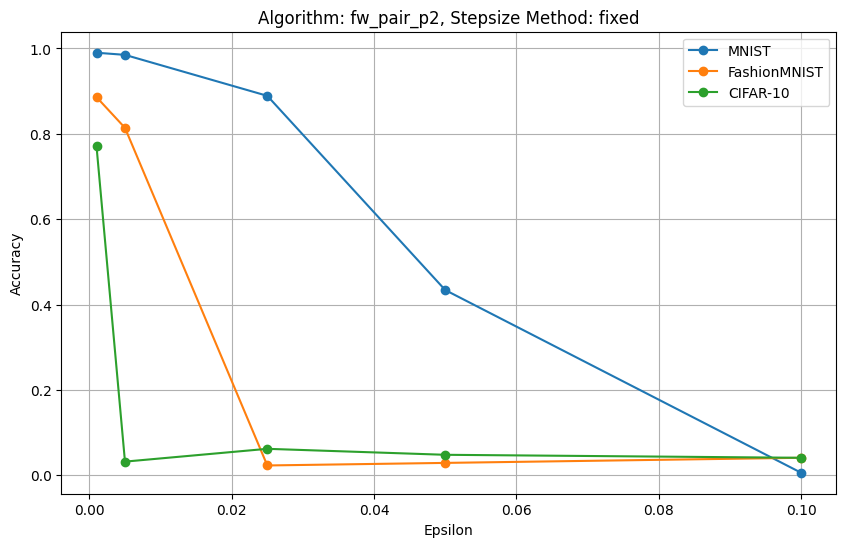

In [6]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair_p2', early_stopping='gap_FW', fw_stepsize_rule='fixed', gap_FW_tol=0.1)

Epsilon: 0.001	Test Accuracy = 993 / 1000 = 0.993
Epsilon: 0.001	Test Accuracy = 886 / 1000 = 0.886
Epsilon: 0.001	Test Accuracy = 795 / 1000 = 0.795
Epsilon: 0.005	Test Accuracy = 983 / 1000 = 0.983
Epsilon: 0.005	Test Accuracy = 814 / 1000 = 0.814
Epsilon: 0.005	Test Accuracy = 384 / 1000 = 0.384
Epsilon: 0.025	Test Accuracy = 980 / 1000 = 0.98
Epsilon: 0.025	Test Accuracy = 440 / 1000 = 0.44
Epsilon: 0.025	Test Accuracy = 152 / 1000 = 0.152
Epsilon: 0.05	Test Accuracy = 961 / 1000 = 0.961
Epsilon: 0.05	Test Accuracy = 227 / 1000 = 0.227
Epsilon: 0.05	Test Accuracy = 105 / 1000 = 0.105
Epsilon: 0.1	Test Accuracy = 415 / 1000 = 0.415
Epsilon: 0.1	Test Accuracy = 55 / 1000 = 0.055
Epsilon: 0.1	Test Accuracy = 57 / 1000 = 0.057
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.001000,False,False,9,9,gap,0.000000
1,1,1,0.001000,False,False,1,1,gap,0.000000
2,2,1,0.001000,False,False,5,5,gap,0.000000
3,3,1,0.001000,False,False,6,6,gap,0.000000
4,4,1,0.001000,False,False,5,5,gap,0.000000
...,...,...,...,...,...,...,...,...,...
5763,997,2,0.066078,True,True,8,5,gap,0.033922
5764,998,1,0.100000,False,False,2,2,None,0.000000
5765,998,2,0.059477,True,True,2,3,gap,0.040523
5766,999,1,0.100000,True,True,7,9,None,0.000000


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.001000,False,False,9,9,gap,0.000000
1,1,1,0.001000,False,False,2,2,gap,0.000000
2,2,1,0.001000,False,False,1,1,gap,0.000000
3,3,1,0.001000,False,False,1,1,gap,0.000000
4,4,1,0.001000,False,False,6,6,gap,0.000000
...,...,...,...,...,...,...,...,...,...
6411,996,2,0.098998,True,False,3,0,gap,0.001002
6412,998,1,0.100000,True,True,7,8,None,0.000000
6413,998,2,0.093853,True,False,7,8,gap,0.006147
6414,999,1,0.100000,True,True,7,9,None,0.000000


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,1,1,0.001000,False,False,2,2,gap,0.000000
1,2,1,0.001000,True,True,3,0,gap,0.000000
2,3,1,0.001000,False,False,7,7,gap,0.000000
3,4,1,0.001000,False,False,8,8,gap,0.000000
4,5,1,0.001000,False,False,7,7,gap,0.000000
...,...,...,...,...,...,...,...,...,...
8861,997,2,0.093090,True,True,1,2,gap,0.006910
8862,998,1,0.100000,True,True,1,2,None,0.000000
8863,998,2,0.093811,True,False,1,2,gap,0.006189
8864,999,1,0.100000,True,True,0,3,None,0.000000


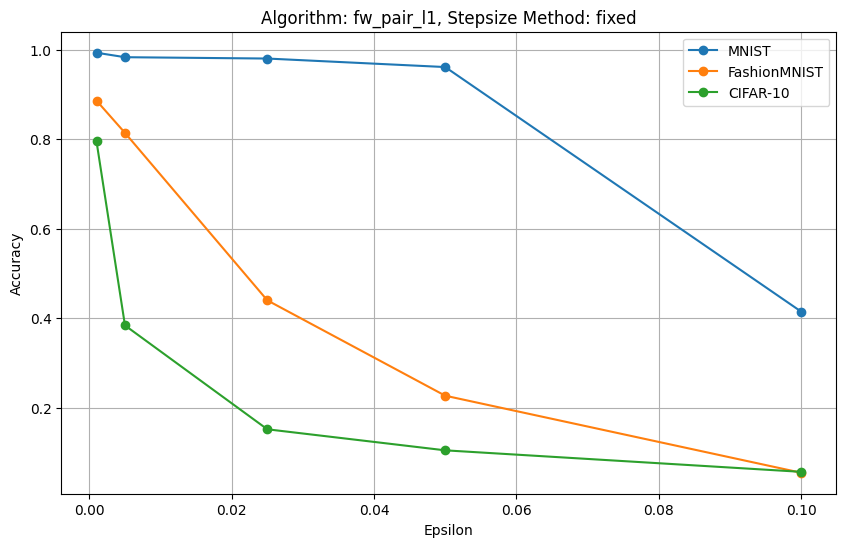

In [7]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair_l1', early_stopping='gap_FW', fw_stepsize_rule='fixed', gap_FW_tol=0.1)

Epsilon: 0.001	Test Accuracy = 991 / 1000 = 0.991
Epsilon: 0.001	Test Accuracy = 886 / 1000 = 0.886
Epsilon: 0.001	Test Accuracy = 775 / 1000 = 0.775
Epsilon: 0.005	Test Accuracy = 985 / 1000 = 0.985
Epsilon: 0.005	Test Accuracy = 814 / 1000 = 0.814
Epsilon: 0.005	Test Accuracy = 28 / 1000 = 0.028
Epsilon: 0.025	Test Accuracy = 919 / 1000 = 0.919
Epsilon: 0.025	Test Accuracy = 23 / 1000 = 0.023
Epsilon: 0.025	Test Accuracy = 60 / 1000 = 0.06
Epsilon: 0.05	Test Accuracy = 412 / 1000 = 0.412
Epsilon: 0.05	Test Accuracy = 29 / 1000 = 0.029
Epsilon: 0.05	Test Accuracy = 46 / 1000 = 0.046
Epsilon: 0.1	Test Accuracy = 9 / 1000 = 0.009
Epsilon: 0.1	Test Accuracy = 41 / 1000 = 0.041
Epsilon: 0.1	Test Accuracy = 39 / 1000 = 0.039
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.019196,False,False,6,6,gap,0.000000
1,1,1,0.019911,False,False,7,7,gap,0.000000
2,2,1,0.016882,False,False,5,5,gap,0.000000
3,3,1,0.017356,False,False,2,2,gap,0.000000
4,4,1,0.017654,False,False,4,4,gap,0.000000
...,...,...,...,...,...,...,...,...,...
17692,999,1,1.882720,False,False,9,9,None,0.000000
17693,999,2,0.935660,True,True,9,4,None,0.915720
17694,999,3,1.025425,True,False,9,4,None,0.866252
17695,999,4,0.343831,True,False,9,4,None,1.495926


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.012190,False,False,9,9,gap,0.000000
1,1,1,0.016750,False,False,2,2,gap,0.000000
2,2,1,0.013429,False,False,1,1,gap,0.000000
3,3,1,0.012161,False,False,1,1,gap,0.000000
4,4,1,0.016396,False,False,6,6,gap,0.000000
...,...,...,...,...,...,...,...,...,...
36590,999,11,1.414718,True,False,7,9,None,0.160578
36591,999,12,1.414718,True,False,7,9,None,0.160578
36592,999,13,1.414718,True,False,7,9,None,0.160578
36593,999,14,1.414718,True,False,7,9,None,0.160578


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.036286,False,False,4,4,gap,0.000000
1,1,1,0.038401,False,False,8,8,gap,0.000000
2,3,1,0.037165,False,False,1,1,gap,0.000000
3,4,1,0.038226,True,True,3,4,gap,0.000000
4,5,1,0.037097,False,False,7,7,gap,0.000000
...,...,...,...,...,...,...,...,...,...
50497,999,11,4.360047,True,False,1,6,None,-0.162503
50498,999,12,4.360047,True,False,1,6,None,-0.162503
50499,999,13,4.360047,True,False,1,6,None,-0.162503
50500,999,14,4.360047,True,False,1,6,None,-0.162503


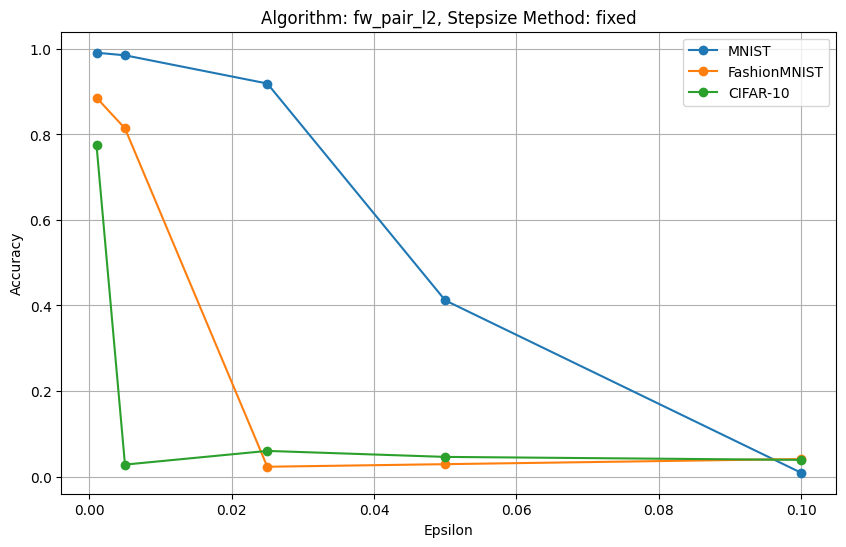

In [8]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair_l2', early_stopping='gap_FW', fw_stepsize_rule='fixed', gap_FW_tol=0.1)

In [ ]:
### ACC VS EPS pairwise, decaying stepsize, different norms

Epsilon: 0.001	Test Accuracy = 992 / 1000 = 0.992
Epsilon: 0.001	Test Accuracy = 879 / 1000 = 0.879
Epsilon: 0.001	Test Accuracy = 580 / 1000 = 0.58
Epsilon: 0.005	Test Accuracy = 984 / 1000 = 0.984
Epsilon: 0.005	Test Accuracy = 623 / 1000 = 0.623
Epsilon: 0.005	Test Accuracy = 15 / 1000 = 0.015
Epsilon: 0.025	Test Accuracy = 929 / 1000 = 0.929
Epsilon: 0.025	Test Accuracy = 17 / 1000 = 0.017
Epsilon: 0.025	Test Accuracy = 52 / 1000 = 0.052
Epsilon: 0.05	Test Accuracy = 631 / 1000 = 0.631
Epsilon: 0.05	Test Accuracy = 27 / 1000 = 0.027
Epsilon: 0.05	Test Accuracy = 59 / 1000 = 0.059
Epsilon: 0.1	Test Accuracy = 30 / 1000 = 0.03
Epsilon: 0.1	Test Accuracy = 41 / 1000 = 0.041
Epsilon: 0.1	Test Accuracy = 41 / 1000 = 0.041
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.075126,False,False,4,4,gap,0.000000
1,1,1,0.077780,False,False,1,1,gap,0.000000
2,2,1,0.082823,False,False,3,3,gap,0.000000
3,3,1,0.076770,False,False,5,5,gap,0.000000
4,4,1,0.058362,False,False,8,8,gap,0.000000
...,...,...,...,...,...,...,...,...,...
15762,998,2,0.044929,True,False,9,5,gap,0.025191
15763,999,1,5.539380,False,False,6,6,None,0.000000
15764,999,2,2.155413,False,False,6,6,None,1.557162
15765,999,3,0.151376,True,True,6,9,None,0.144193


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.964374,False,False,9,9,None,0.000000
1,0,2,0.382317,False,False,9,9,None,0.590578
2,0,3,-0.016278,False,False,9,9,gap,0.977765
3,1,1,0.479053,False,False,2,2,None,0.000000
4,1,2,0.119141,False,False,2,2,None,0.366032
...,...,...,...,...,...,...,...,...,...
17462,999,11,3.652767,True,False,7,9,None,0.414609
17463,999,12,3.652767,True,False,7,9,None,0.414609
17464,999,13,3.652767,True,False,7,9,None,0.414609
17465,999,14,3.652767,True,False,7,9,None,0.414609


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.360960,True,True,5,3,None,0.000000
1,0,2,0.006014,True,False,5,3,gap,0.019077
2,1,1,0.363478,False,False,7,7,None,0.000000
3,1,2,0.095733,False,False,7,7,gap,0.228291
4,2,1,0.740244,True,True,1,9,None,0.000000
...,...,...,...,...,...,...,...,...,...
17307,997,2,0.021355,True,False,8,2,gap,0.000958
17308,998,1,125.048859,True,True,7,2,None,0.000000
17309,998,2,0.001155,True,False,7,2,gap,0.000064
17310,999,1,54.409840,True,True,7,6,None,0.000000


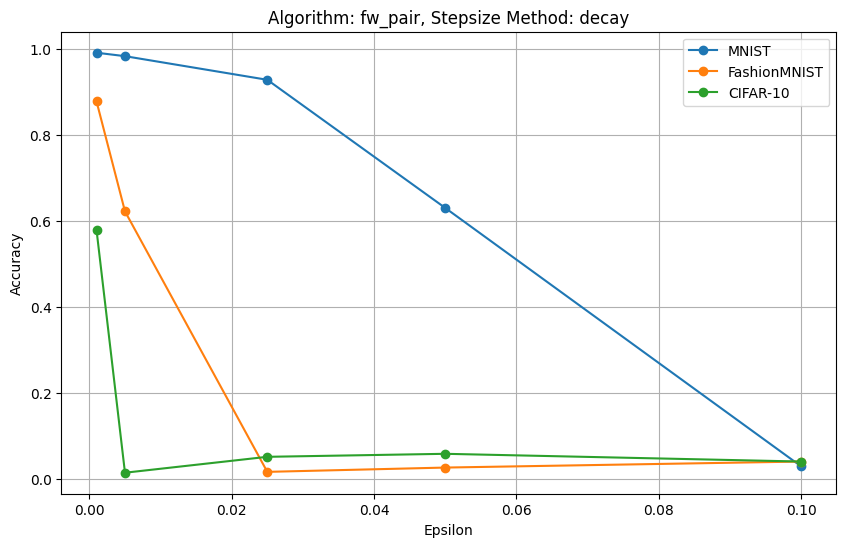

In [9]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair', early_stopping='gap_FW', fw_stepsize_rule='decay', gap_FW_tol=0.1)

Epsilon: 0.001	Test Accuracy = 990 / 1000 = 0.99
Epsilon: 0.001	Test Accuracy = 886 / 1000 = 0.886
Epsilon: 0.001	Test Accuracy = 785 / 1000 = 0.785
Epsilon: 0.005	Test Accuracy = 987 / 1000 = 0.987
Epsilon: 0.005	Test Accuracy = 814 / 1000 = 0.814
Epsilon: 0.005	Test Accuracy = 34 / 1000 = 0.034
Epsilon: 0.025	Test Accuracy = 942 / 1000 = 0.942
Epsilon: 0.025	Test Accuracy = 20 / 1000 = 0.02
Epsilon: 0.025	Test Accuracy = 53 / 1000 = 0.053
Epsilon: 0.05	Test Accuracy = 672 / 1000 = 0.672
Epsilon: 0.05	Test Accuracy = 27 / 1000 = 0.027
Epsilon: 0.05	Test Accuracy = 60 / 1000 = 0.06
Epsilon: 0.1	Test Accuracy = 6 / 1000 = 0.006
Epsilon: 0.1	Test Accuracy = 41 / 1000 = 0.041
Epsilon: 0.1	Test Accuracy = 46 / 1000 = 0.046
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.015293,False,False,5,5,gap,0.000000
1,1,1,0.020615,False,False,0,0,gap,0.000000
2,2,1,0.018695,False,False,7,7,gap,0.000000
3,3,1,0.015167,False,False,8,8,gap,0.000000
4,4,1,0.018921,False,False,0,0,gap,0.000000
...,...,...,...,...,...,...,...,...,...
18703,998,4,0.075969,True,False,6,9,gap,1.722228
18704,999,1,1.715568,False,False,8,8,None,0.000000
18705,999,2,0.899137,False,False,8,8,None,0.867804
18706,999,3,0.363918,False,False,8,8,None,1.363982


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.012190,False,False,9,9,gap,0.000000
1,1,1,0.016750,False,False,2,2,gap,0.000000
2,2,1,0.013429,False,False,1,1,gap,0.000000
3,3,1,0.012161,False,False,1,1,gap,0.000000
4,4,1,0.016396,False,False,6,6,gap,0.000000
...,...,...,...,...,...,...,...,...,...
37955,999,11,1.414718,True,False,7,9,None,0.160578
37956,999,12,1.414718,True,False,7,9,None,0.160578
37957,999,13,1.414718,True,False,7,9,None,0.160578
37958,999,14,1.414718,True,False,7,9,None,0.160578


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.037356,True,True,5,2,gap,0.000000
1,1,1,0.034320,False,False,5,5,gap,0.000000
2,2,1,0.035017,False,False,1,1,gap,0.000000
3,3,1,0.036592,False,False,8,8,gap,0.000000
4,4,1,0.034451,False,False,4,4,gap,0.000000
...,...,...,...,...,...,...,...,...,...
48406,999,11,3.883765,True,False,0,2,None,0.294018
48407,999,12,3.883765,True,False,0,2,None,0.294018
48408,999,13,3.883765,True,False,0,2,None,0.294018
48409,999,14,3.883765,True,False,0,2,None,0.294018


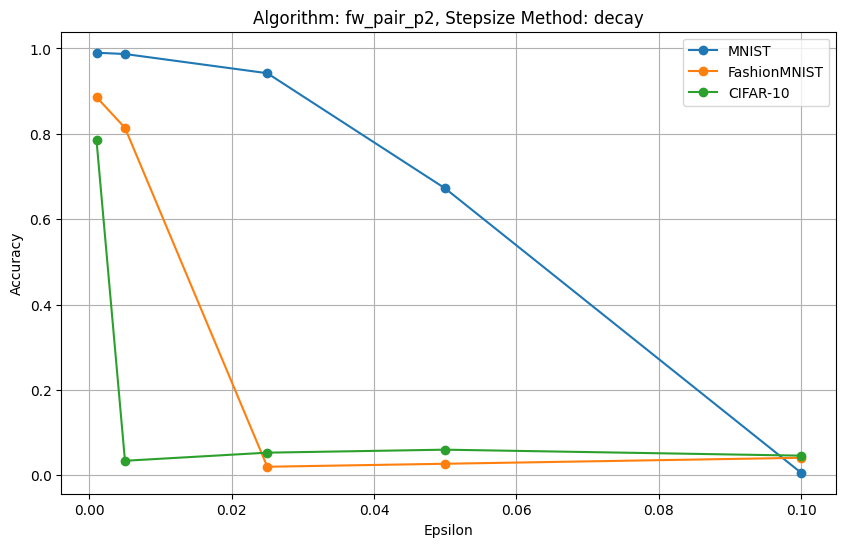

In [10]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair_p2', early_stopping='gap_FW', fw_stepsize_rule='decay', gap_FW_tol=0.1)

Epsilon: 0.001	Test Accuracy = 994 / 1000 = 0.994
Epsilon: 0.001	Test Accuracy = 886 / 1000 = 0.886
Epsilon: 0.001	Test Accuracy = 779 / 1000 = 0.779
Epsilon: 0.005	Test Accuracy = 994 / 1000 = 0.994
Epsilon: 0.005	Test Accuracy = 814 / 1000 = 0.814
Epsilon: 0.005	Test Accuracy = 365 / 1000 = 0.365
Epsilon: 0.025	Test Accuracy = 981 / 1000 = 0.981
Epsilon: 0.025	Test Accuracy = 440 / 1000 = 0.44
Epsilon: 0.025	Test Accuracy = 156 / 1000 = 0.156
Epsilon: 0.05	Test Accuracy = 958 / 1000 = 0.958
Epsilon: 0.05	Test Accuracy = 227 / 1000 = 0.227
Epsilon: 0.05	Test Accuracy = 121 / 1000 = 0.121
Epsilon: 0.1	Test Accuracy = 532 / 1000 = 0.532
Epsilon: 0.1	Test Accuracy = 55 / 1000 = 0.055
Epsilon: 0.1	Test Accuracy = 52 / 1000 = 0.052
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.001000,False,False,2,2,gap,0.000000
1,1,1,0.001000,False,False,2,2,gap,0.000000
2,2,1,0.001000,False,False,7,7,gap,0.000000
3,3,1,0.001000,False,False,8,8,gap,0.000000
4,4,1,0.001000,False,False,9,9,gap,0.000000
...,...,...,...,...,...,...,...,...,...
5802,997,2,0.056949,True,True,1,8,gap,0.043051
5803,998,1,0.100000,False,False,1,1,None,0.000000
5804,998,2,0.055972,True,True,1,8,gap,0.044028
5805,999,1,0.100000,False,False,5,5,None,0.000000


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.001000,False,False,9,9,gap,0.000000
1,1,1,0.001000,False,False,2,2,gap,0.000000
2,2,1,0.001000,False,False,1,1,gap,0.000000
3,3,1,0.001000,False,False,1,1,gap,0.000000
4,4,1,0.001000,False,False,6,6,gap,0.000000
...,...,...,...,...,...,...,...,...,...
6351,996,2,0.098998,True,False,3,0,gap,0.001002
6352,998,1,0.100000,True,True,7,8,None,0.000000
6353,998,2,0.093853,True,False,7,8,gap,0.006147
6354,999,1,0.100000,True,True,7,9,None,0.000000


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.001000,True,True,2,3,gap,0.000000
1,1,1,0.001000,False,False,8,8,gap,0.000000
2,2,1,0.001000,False,False,1,1,gap,0.000000
3,4,1,0.001000,False,False,8,8,gap,0.000000
4,5,1,0.001000,False,False,0,0,gap,0.000000
...,...,...,...,...,...,...,...,...,...
9218,996,2,0.094830,True,False,1,6,gap,0.005170
9219,998,1,0.100000,True,True,4,6,None,0.000000
9220,998,2,0.093906,True,False,4,6,gap,0.006094
9221,999,1,0.100000,True,True,9,6,None,0.000000


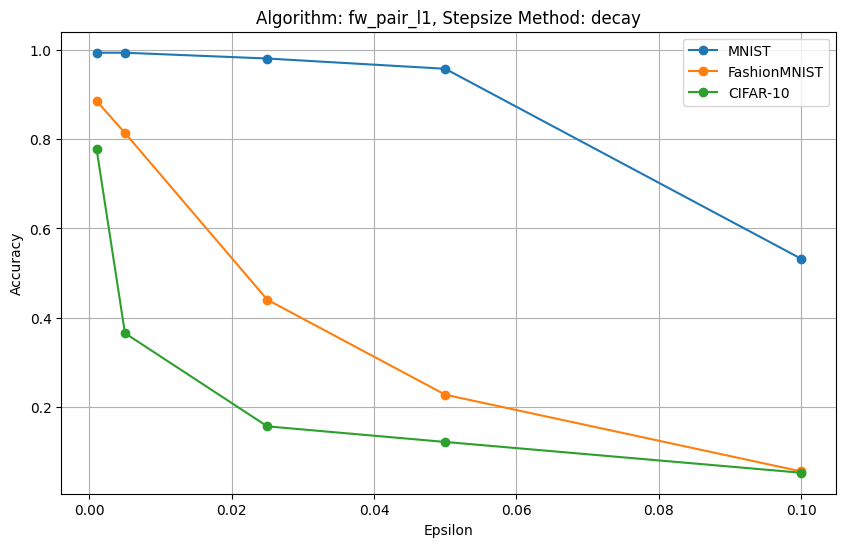

In [11]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair_l1', early_stopping='gap_FW', fw_stepsize_rule='decay', gap_FW_tol=0.1)

Epsilon: 0.001	Test Accuracy = 986 / 1000 = 0.986
Epsilon: 0.001	Test Accuracy = 886 / 1000 = 0.886
Epsilon: 0.001	Test Accuracy = 790 / 1000 = 0.79
Epsilon: 0.005	Test Accuracy = 989 / 1000 = 0.989
Epsilon: 0.005	Test Accuracy = 814 / 1000 = 0.814
Epsilon: 0.005	Test Accuracy = 40 / 1000 = 0.04
Epsilon: 0.025	Test Accuracy = 952 / 1000 = 0.952
Epsilon: 0.025	Test Accuracy = 20 / 1000 = 0.02
Epsilon: 0.025	Test Accuracy = 56 / 1000 = 0.056
Epsilon: 0.05	Test Accuracy = 657 / 1000 = 0.657
Epsilon: 0.05	Test Accuracy = 27 / 1000 = 0.027
Epsilon: 0.05	Test Accuracy = 52 / 1000 = 0.052
Epsilon: 0.1	Test Accuracy = 7 / 1000 = 0.007
Epsilon: 0.1	Test Accuracy = 41 / 1000 = 0.041
Epsilon: 0.1	Test Accuracy = 45 / 1000 = 0.045
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.019590,False,False,2,2,gap,0.000000
1,1,1,0.017418,False,False,7,7,gap,0.000000
2,2,1,0.018689,False,False,3,3,gap,0.000000
3,3,1,0.015251,False,False,5,5,gap,0.000000
4,4,1,0.018957,False,False,2,2,gap,0.000000
...,...,...,...,...,...,...,...,...,...
18605,999,11,1.446704,True,False,4,3,None,0.534939
18606,999,12,1.446704,True,False,4,3,None,0.534939
18607,999,13,1.446704,True,False,4,3,None,0.534939
18608,999,14,1.446704,True,False,4,3,None,0.534939


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.012190,False,False,9,9,gap,0.000000
1,1,1,0.016750,False,False,2,2,gap,0.000000
2,2,1,0.013429,False,False,1,1,gap,0.000000
3,3,1,0.012161,False,False,1,1,gap,0.000000
4,4,1,0.016396,False,False,6,6,gap,0.000000
...,...,...,...,...,...,...,...,...,...
37955,999,11,1.414718,True,False,7,9,None,0.160578
37956,999,12,1.414718,True,False,7,9,None,0.160578
37957,999,13,1.414718,True,False,7,9,None,0.160578
37958,999,14,1.414718,True,False,7,9,None,0.160578


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.036584,False,False,6,6,gap,0.00000
1,1,1,0.030625,False,False,3,3,gap,0.00000
2,3,1,0.038261,False,False,9,9,gap,0.00000
3,4,1,0.036559,False,False,2,2,gap,0.00000
4,5,1,0.034290,False,False,3,3,gap,0.00000
...,...,...,...,...,...,...,...,...,...
47972,999,11,4.395289,True,False,3,6,None,0.07078
47973,999,12,4.395289,True,False,3,6,None,0.07078
47974,999,13,4.395289,True,False,3,6,None,0.07078
47975,999,14,4.395289,True,False,3,6,None,0.07078


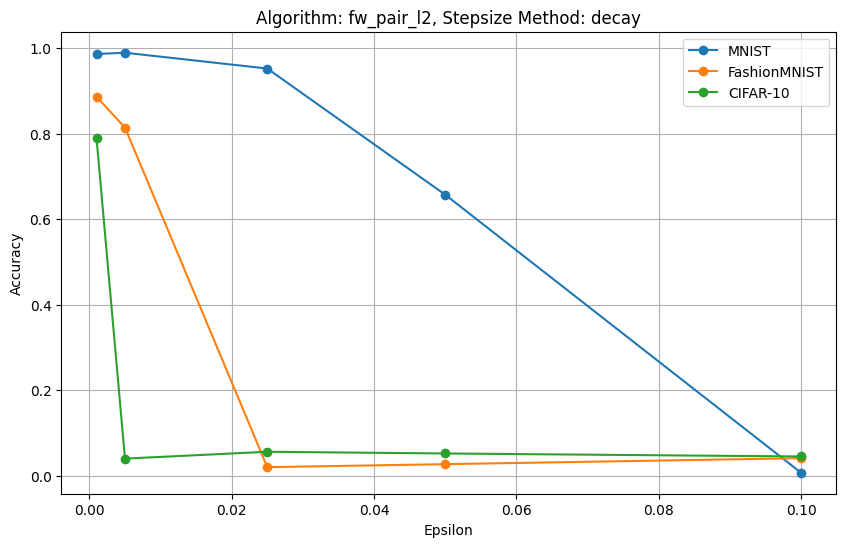

In [12]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair_l2', early_stopping='gap_FW', fw_stepsize_rule='decay', gap_FW_tol=0.1)

### ACC VS EPS pairwise, line search stepsize, different norms

Epsilon: 0.001	Test Accuracy = 989 / 1000 = 0.989
Epsilon: 0.001	Test Accuracy = 870 / 1000 = 0.87
Epsilon: 0.001	Test Accuracy = 513 / 1000 = 0.513
Epsilon: 0.005	Test Accuracy = 992 / 1000 = 0.992
Epsilon: 0.005	Test Accuracy = 526 / 1000 = 0.526
Epsilon: 0.005	Test Accuracy = 18 / 1000 = 0.018
Epsilon: 0.025	Test Accuracy = 895 / 1000 = 0.895
Epsilon: 0.025	Test Accuracy = 11 / 1000 = 0.011
Epsilon: 0.025	Test Accuracy = 34 / 1000 = 0.034
Epsilon: 0.05	Test Accuracy = 311 / 1000 = 0.311
Epsilon: 0.05	Test Accuracy = 17 / 1000 = 0.017
Epsilon: 0.05	Test Accuracy = 43 / 1000 = 0.043
Epsilon: 0.1	Test Accuracy = 1 / 1000 = 0.001
Epsilon: 0.1	Test Accuracy = 22 / 1000 = 0.022
Epsilon: 0.1	Test Accuracy = 31 / 1000 = 0.031
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.064928,False,False,4,4,gap,0.000000
1,1,1,0.056068,False,False,5,5,gap,0.000000
2,2,1,0.080316,False,False,5,5,gap,0.000000
3,3,1,0.071408,False,False,3,3,gap,0.000000
4,4,1,0.059660,False,False,0,0,gap,0.000000
...,...,...,...,...,...,...,...,...,...
14327,998,3,0.016737,True,False,8,9,gap,0.012729
14328,999,1,8.462796,False,False,2,2,None,0.000000
14329,999,2,4.830849,False,False,2,2,None,3.829513
14330,999,3,0.717671,True,True,2,8,None,1.544531


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.964374,False,False,9,9,None,0.000000
1,0,2,0.382317,False,False,9,9,None,0.590578
2,0,3,-0.185004,False,False,9,9,gap,1.118248
3,1,1,0.479053,False,False,2,2,None,0.000000
4,1,2,0.119141,False,False,2,2,None,0.366032
...,...,...,...,...,...,...,...,...,...
16243,999,11,3.652767,True,False,7,9,None,0.414609
16244,999,12,3.652767,True,False,7,9,None,0.414609
16245,999,13,3.652767,True,False,7,9,None,0.414609
16246,999,14,3.652767,True,False,7,9,None,0.414609


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.467866,False,False,1,1,None,0.000000
1,0,2,0.051642,False,False,1,1,gap,0.456348
2,1,1,0.900090,False,False,2,2,None,0.000000
3,1,2,0.179088,False,False,2,2,None,0.617827
4,1,3,-0.154331,True,True,2,3,gap,0.562180
...,...,...,...,...,...,...,...,...,...
17830,997,2,0.020324,True,False,4,2,gap,0.001255
17831,998,1,50.376816,True,True,1,6,None,0.000000
17832,998,2,0.006440,True,False,1,6,gap,0.000057
17833,999,1,98.839249,True,True,0,2,None,0.000000


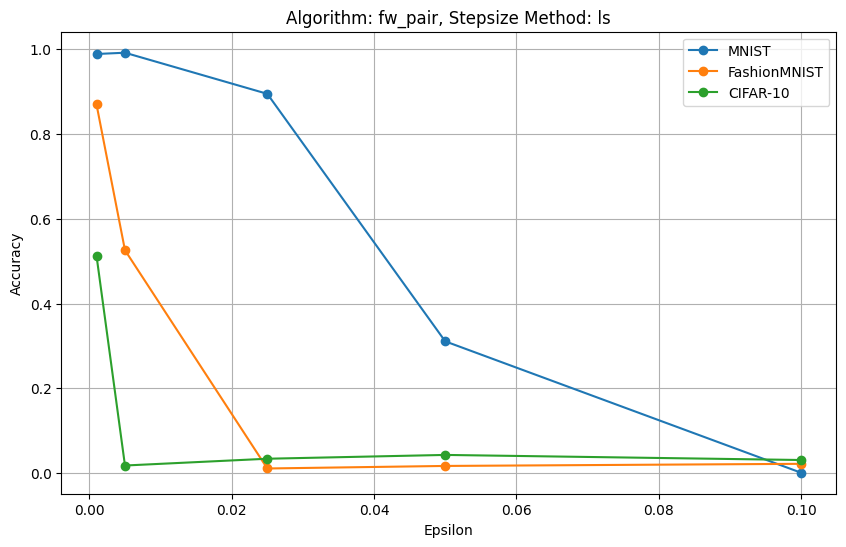

In [13]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair', early_stopping='gap_FW', fw_stepsize_rule='ls', gap_FW_tol=0.1)

Epsilon: 0.001	Test Accuracy = 986 / 1000 = 0.986
Epsilon: 0.001	Test Accuracy = 886 / 1000 = 0.886
Epsilon: 0.001	Test Accuracy = 842 / 1000 = 0.842
Epsilon: 0.005	Test Accuracy = 987 / 1000 = 0.987
Epsilon: 0.005	Test Accuracy = 814 / 1000 = 0.814
Epsilon: 0.005	Test Accuracy = 55 / 1000 = 0.055
Epsilon: 0.025	Test Accuracy = 889 / 1000 = 0.889
Epsilon: 0.025	Test Accuracy = 13 / 1000 = 0.013
Epsilon: 0.025	Test Accuracy = 36 / 1000 = 0.036
Epsilon: 0.05	Test Accuracy = 449 / 1000 = 0.449
Epsilon: 0.05	Test Accuracy = 17 / 1000 = 0.017
Epsilon: 0.05	Test Accuracy = 35 / 1000 = 0.035
Epsilon: 0.1	Test Accuracy = 8 / 1000 = 0.008
Epsilon: 0.1	Test Accuracy = 22 / 1000 = 0.022
Epsilon: 0.1	Test Accuracy = 33 / 1000 = 0.033
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.020313,False,False,2,2,gap,0.000000
1,1,1,0.018823,False,False,3,3,gap,0.000000
2,2,1,0.018384,False,False,9,9,gap,0.000000
3,3,1,0.019529,False,False,2,2,gap,0.000000
4,4,1,0.017822,False,False,9,9,gap,0.000000
...,...,...,...,...,...,...,...,...,...
17871,999,1,1.763146,True,True,3,8,None,0.000000
17872,999,2,1.127949,True,False,3,8,None,0.643410
17873,999,3,0.529746,True,False,3,8,None,1.246175
17874,999,4,0.192873,True,False,3,8,None,1.574632


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.012190,False,False,9,9,gap,0.000000
1,1,1,0.016750,False,False,2,2,gap,0.000000
2,2,1,0.013429,False,False,1,1,gap,0.000000
3,3,1,0.012161,False,False,1,1,gap,0.000000
4,4,1,0.016396,False,False,6,6,gap,0.000000
...,...,...,...,...,...,...,...,...,...
38084,999,11,1.414718,True,False,7,9,None,0.160578
38085,999,12,1.414718,True,False,7,9,None,0.160578
38086,999,13,1.414718,True,False,7,9,None,0.160578
38087,999,14,1.414718,True,False,7,9,None,0.160578


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.034283,True,True,6,3,gap,0.000000
1,1,1,0.039129,False,False,8,8,gap,0.000000
2,2,1,0.035641,False,False,0,0,gap,0.000000
3,3,1,0.034725,False,False,7,7,gap,0.000000
4,4,1,0.035461,False,False,8,8,gap,0.000000
...,...,...,...,...,...,...,...,...,...
49557,999,11,3.894720,True,False,1,2,None,0.175828
49558,999,12,3.894720,True,False,1,2,None,0.175828
49559,999,13,3.894720,True,False,1,2,None,0.175828
49560,999,14,3.894720,True,False,1,2,None,0.175828


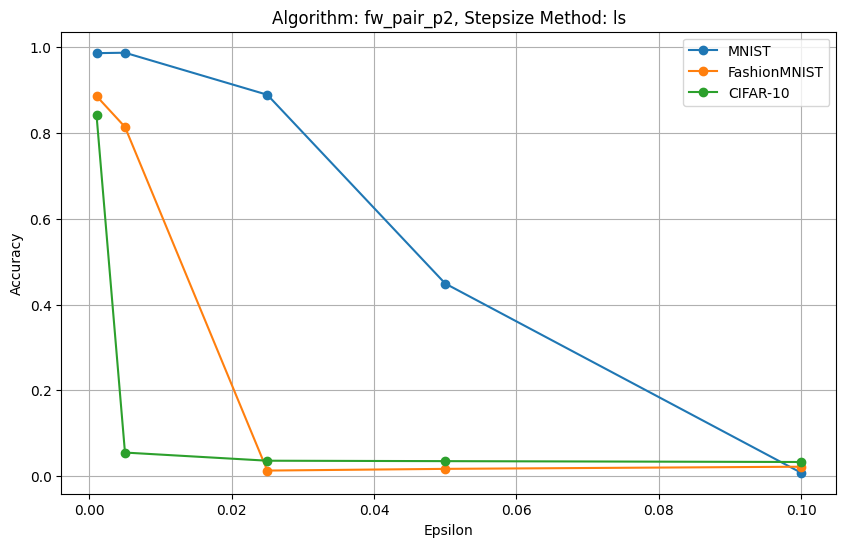

In [14]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair_p2', early_stopping='gap_FW', fw_stepsize_rule='ls', gap_FW_tol=0.1)

Epsilon: 0.001	Test Accuracy = 991 / 1000 = 0.991
Epsilon: 0.001	Test Accuracy = 886 / 1000 = 0.886
Epsilon: 0.001	Test Accuracy = 806 / 1000 = 0.806
Epsilon: 0.005	Test Accuracy = 995 / 1000 = 0.995
Epsilon: 0.005	Test Accuracy = 814 / 1000 = 0.814
Epsilon: 0.005	Test Accuracy = 466 / 1000 = 0.466
Epsilon: 0.025	Test Accuracy = 984 / 1000 = 0.984
Epsilon: 0.025	Test Accuracy = 441 / 1000 = 0.441
Epsilon: 0.025	Test Accuracy = 196 / 1000 = 0.196
Epsilon: 0.05	Test Accuracy = 955 / 1000 = 0.955
Epsilon: 0.05	Test Accuracy = 233 / 1000 = 0.233
Epsilon: 0.05	Test Accuracy = 124 / 1000 = 0.124
Epsilon: 0.1	Test Accuracy = 396 / 1000 = 0.396
Epsilon: 0.1	Test Accuracy = 48 / 1000 = 0.048
Epsilon: 0.1	Test Accuracy = 49 / 1000 = 0.049
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.001000,False,False,8,8,gap,0.000000
1,1,1,0.001000,False,False,0,0,gap,0.000000
2,2,1,0.001000,False,False,4,4,gap,0.000000
3,3,1,0.001000,False,False,9,9,gap,0.000000
4,4,1,0.001000,False,False,3,3,gap,0.000000
...,...,...,...,...,...,...,...,...,...
5789,997,1,0.100000,False,False,7,7,gap,0.000000
5790,998,1,0.100000,False,False,0,0,None,0.000000
5791,998,2,0.063187,True,True,0,6,gap,0.036813
5792,999,1,0.100000,False,False,5,5,None,0.000000


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.001000,False,False,9,9,gap,0.000000
1,1,1,0.001000,False,False,2,2,gap,0.000000
2,2,1,0.001000,False,False,1,1,gap,0.000000
3,3,1,0.001000,False,False,1,1,gap,0.000000
4,4,1,0.001000,False,False,6,6,gap,0.000000
...,...,...,...,...,...,...,...,...,...
5760,996,2,0.098998,True,False,3,0,gap,0.001002
5761,998,1,0.100000,True,True,7,5,None,0.000000
5762,998,2,0.095331,True,False,7,8,gap,0.004669
5763,999,1,0.100000,True,True,7,9,None,0.000000


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.001000,False,False,0,0,gap,0.000000
1,1,1,0.001000,False,False,2,2,gap,0.000000
2,2,1,0.001000,False,False,7,7,gap,0.000000
3,3,1,0.001000,False,False,4,4,gap,0.000000
4,4,1,0.001000,True,True,0,8,gap,0.000000
...,...,...,...,...,...,...,...,...,...
9365,999,11,0.100751,True,False,8,2,None,-0.000059
9366,999,12,0.100751,True,False,8,2,None,-0.000059
9367,999,13,0.100751,True,False,8,2,None,-0.000059
9368,999,14,0.100751,True,False,8,2,None,-0.000059


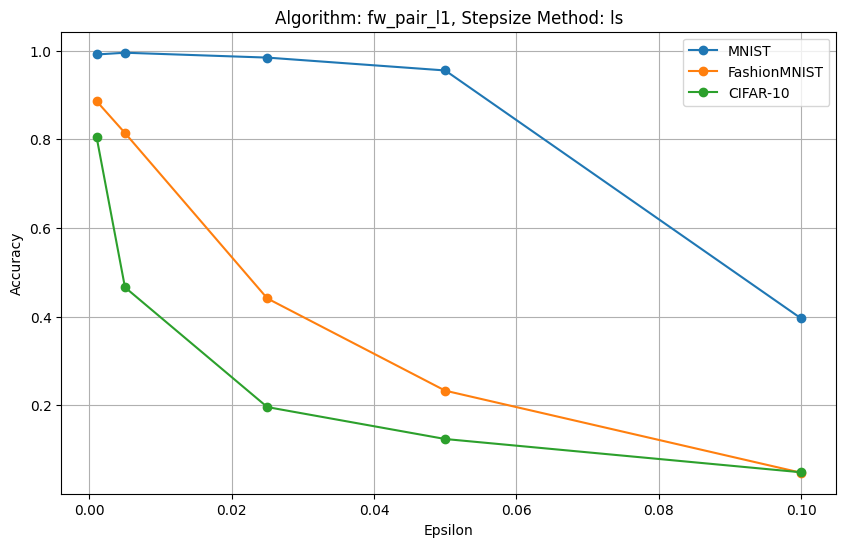

In [15]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair_l1', early_stopping='gap_FW', fw_stepsize_rule='ls', gap_FW_tol=0.1)

Epsilon: 0.001	Test Accuracy = 994 / 1000 = 0.994
Epsilon: 0.001	Test Accuracy = 886 / 1000 = 0.886
Epsilon: 0.001	Test Accuracy = 817 / 1000 = 0.817
Epsilon: 0.005	Test Accuracy = 988 / 1000 = 0.988
Epsilon: 0.005	Test Accuracy = 814 / 1000 = 0.814
Epsilon: 0.005	Test Accuracy = 55 / 1000 = 0.055
Epsilon: 0.025	Test Accuracy = 906 / 1000 = 0.906
Epsilon: 0.025	Test Accuracy = 13 / 1000 = 0.013
Epsilon: 0.025	Test Accuracy = 44 / 1000 = 0.044
Epsilon: 0.05	Test Accuracy = 411 / 1000 = 0.411
Epsilon: 0.05	Test Accuracy = 17 / 1000 = 0.017
Epsilon: 0.05	Test Accuracy = 40 / 1000 = 0.04
Epsilon: 0.1	Test Accuracy = 5 / 1000 = 0.005
Epsilon: 0.1	Test Accuracy = 22 / 1000 = 0.022
Epsilon: 0.1	Test Accuracy = 38 / 1000 = 0.038
Historical DataFrame for MNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.017626,False,False,9,9,gap,0.000000
1,1,1,0.018569,False,False,8,8,gap,0.000000
2,2,1,0.016664,False,False,1,1,gap,0.000000
3,3,1,0.017463,False,False,8,8,gap,0.000000
4,4,1,0.018012,False,False,3,3,gap,0.000000
...,...,...,...,...,...,...,...,...,...
18020,999,2,0.860013,True,True,8,5,None,0.791970
18021,999,3,0.938457,True,False,8,5,None,0.807896
18022,999,4,0.588103,True,False,8,5,None,1.126659
18023,999,5,0.211854,True,False,8,5,None,1.376064


Historical DataFrame for FashionMNIST


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.012190,False,False,9,9,gap,0.000000
1,1,1,0.016750,False,False,2,2,gap,0.000000
2,2,1,0.013429,False,False,1,1,gap,0.000000
3,3,1,0.012161,False,False,1,1,gap,0.000000
4,4,1,0.016396,False,False,6,6,gap,0.000000
...,...,...,...,...,...,...,...,...,...
38084,999,11,1.414718,True,False,7,9,None,0.160578
38085,999,12,1.414718,True,False,7,9,None,0.160578
38086,999,13,1.414718,True,False,7,9,None,0.160578
38087,999,14,1.414718,True,False,7,9,None,0.160578


Historical DataFrame for CIFAR-10


,example_idx,FW_iter,gap_FW,success,first_success,target,pred,stop_cond,gap_AS
0,0,1,0.035406,False,False,1,1,gap,0.000000
1,1,1,0.034894,False,False,5,5,gap,0.000000
2,2,1,0.035099,False,False,7,7,gap,0.000000
3,3,1,0.035231,True,True,6,2,gap,0.000000
4,4,1,0.036667,False,False,9,9,gap,0.000000
...,...,...,...,...,...,...,...,...,...
49986,999,11,3.740469,True,False,4,5,None,0.346416
49987,999,12,3.740469,True,False,4,5,None,0.346416
49988,999,13,3.740469,True,False,4,5,None,0.346416
49989,999,14,3.740469,True,False,4,5,None,0.346416


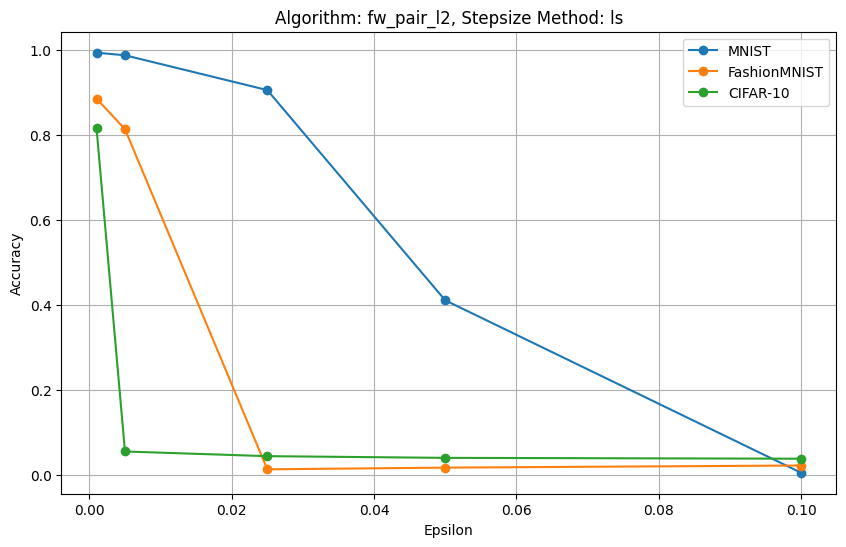

In [16]:
history_acc_eps(test_fw, datasets, devices, eps, 15, method='fw_pair_l2', early_stopping='gap_FW', fw_stepsize_rule='ls', gap_FW_tol=0.1)